In [33]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Load and clean data
df = pd.read_csv("articles.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date:         79 non-null     object
 1   Title:        79 non-null     object
 2   URL:          80 non-null     object
 3   Publication:  80 non-null     object
 4   Author:       80 non-null     object
 5   Pro-Anti:     80 non-null     object
 6   Topic #:      78 non-null     object
 7   Content:      79 non-null     object
dtypes: object(8)
memory usage: 5.1+ KB


In [39]:
df['Pro-Anti:'] = df['Pro-Anti:'].str.strip()
df['Pro-Anti:'].value_counts()

Pro-Anti:
Pro     63
Anti    17
Name: count, dtype: int64

In [40]:
df['Pro-Anti:'].unique()

array(['Pro', 'Anti'], dtype=object)

In [41]:
print(df.columns.tolist())

['Date:', 'Title:', 'URL:', 'Publication:', 'Author:', 'Pro-Anti:', 'Topic #:', 'Content:']


Epoch 01 │ Loss 3.8171 │ Accuracy 56.41%
Epoch 02 │ Loss 3.2726 │ Accuracy 52.56%
Epoch 03 │ Loss 3.0006 │ Accuracy 61.54%
Epoch 04 │ Loss 2.2178 │ Accuracy 67.95%
Epoch 05 │ Loss 1.7542 │ Accuracy 73.08%
Epoch 06 │ Loss 1.6025 │ Accuracy 76.92%
Epoch 07 │ Loss 0.6650 │ Accuracy 76.92%
Epoch 08 │ Loss 0.6933 │ Accuracy 74.36%
Epoch 09 │ Loss 0.1857 │ Accuracy 75.64%
Epoch 10 │ Loss 0.4397 │ Accuracy 78.21%


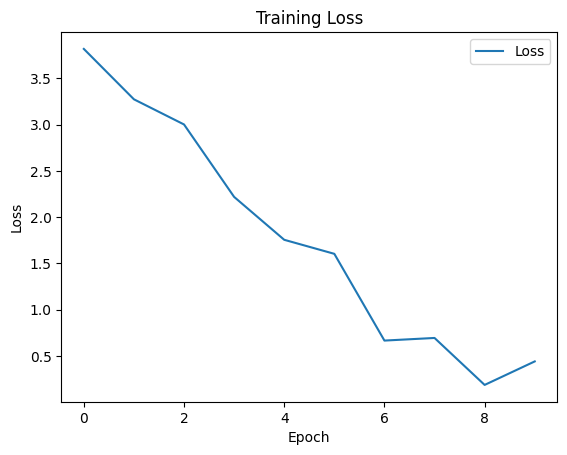

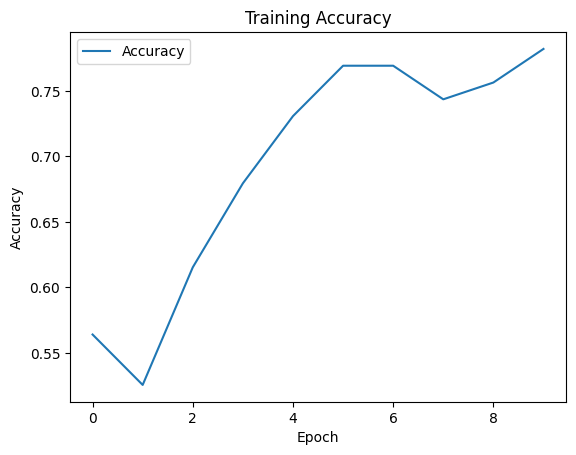

In [42]:

df = df.dropna(subset=["Content:", "Topic #:", "Pro-Anti:"])
df["label"] = df["Pro-Anti:"].map({"Pro": 1, "Anti": 0})
df["topic_id"] = LabelEncoder().fit_transform(df["Topic #:"].astype(str))

# TF-IDF for content
vectorizer = TfidfVectorizer(max_features=500)
X_text = vectorizer.fit_transform(df["Content:"]).toarray()

# One-hot encode topic
topic_embeddings = np.eye(df["topic_id"].nunique())[df["topic_id"]]
X_combined = np.hstack((X_text, topic_embeddings))

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_combined, dtype=torch.float32)
y_tensor = torch.tensor(df["label"].values, dtype=torch.long)

# Custom Dataset
class ArticleDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

dataset = ArticleDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Policy Network
class PolicyNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.policy_head = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.policy_head(x), dim=-1)

model = PolicyNet(input_dim=X_tensor.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop with REINFORCE
losses, accuracies = [], []
for epoch in range(10):
    total_loss, correct, total = 0, 0, 0
    for states, labels in dataloader:
        probs = model(states)
        dist = torch.distributions.Categorical(probs)
        actions = dist.sample()
        rewards = (actions == labels).float()
        log_probs = dist.log_prob(actions)
        loss = -(log_probs * rewards).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (actions == labels).sum().item()
        total += len(labels)

    acc = correct / total
    losses.append(total_loss)
    accuracies.append(acc)
    print(f"Epoch {epoch+1:02d} │ Loss {total_loss:.4f} │ Accuracy {acc:.2%}")

# Plotting
plt.plot(losses, label="Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(accuracies, label="Accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [43]:
print(df["stance"].unique())
print(df["label"].unique())

KeyError: 'stance'

In [44]:
# 1. Install dependencies first (if needed)
# pip install torch transformers pandas scikit-learn

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# 2. Load and clean dataset
df = pd.read_csv("articles.csv")
df.columns = df.columns.str.strip()
df = df.dropna(subset=["Content:", "Topic #:", "Pro-Anti:"])
df = df.rename(columns={"Content:": "content", "Topic #:": "topic", "Pro-Anti:": "stance"})
df["stance"] = df["stance"].str.strip()
df["label"] = df["stance"].map({"Pro": 1, "Anti": 0})
topic_encoder = LabelEncoder()
df["topic_id"] = topic_encoder.fit_transform(df["topic"].astype(str))


In [45]:
print(df["stance"].unique())
print(df["label"].unique())

['Pro' 'Anti']
[1 0]


/Users/georgiavonminden/virtual-env/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 01 │ Loss 11.1307 │ Accuracy 79.49%
Epoch 02 │ Loss 9.0283 │ Accuracy 79.49%
Epoch 03 │ Loss 7.0666 │ Accuracy 80.77%
Epoch 04 │ Loss 4.8479 │ Accuracy 89.74%
Epoch 05 │ Loss 2.1162 │ Accuracy 98.72%


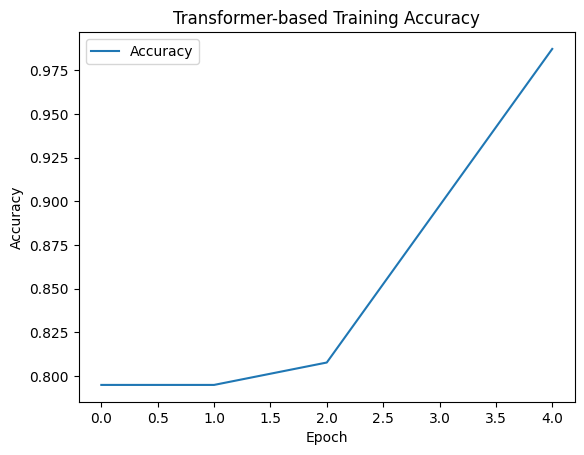

In [46]:

# 3. Tokenizer and Dataset class
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")


class ArticleDataset(Dataset):
    def __init__(self, texts, topics, labels, tokenizer, max_len=256):
        self.texts = texts
        self.topics = topics
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        topic_id = self.topics[idx]
        label = self.labels[idx]
        enc = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "topic_id": torch.tensor(topic_id),
            "label": torch.tensor(label, dtype=torch.long)
        }

# 4. Model
class StanceClassifier(nn.Module):
    def __init__(self, topic_vocab_size, topic_emb_dim=32, bert_model="distilbert-base-uncased"):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained(bert_model)
        self.topic_emb = nn.Embedding(topic_vocab_size, topic_emb_dim)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size + topic_emb_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, input_ids, attention_mask, topic_id):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_embed = outputs.last_hidden_state[:, 0, :]  # CLS token
        topic_embed = self.topic_emb(topic_id)
        x = torch.cat((text_embed, topic_embed), dim=1)
        return self.classifier(x)

# 5. Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = ArticleDataset(df["content"].tolist(), df["topic_id"].values, df["label"].values, tokenizer)
loader = DataLoader(dataset, batch_size=4, shuffle=True)
model = StanceClassifier(topic_vocab_size=len(df["topic_id"].unique())).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# 6. Training loop
losses, accs = [], []
for epoch in range(5):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attn_mask = batch["attention_mask"].to(device)
        topic_id = batch["topic_id"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attn_mask, topic_id)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += len(labels)
        total_loss += loss.item()

    epoch_acc = correct / total
    losses.append(total_loss)
    accs.append(epoch_acc)
    print(f"Epoch {epoch+1:02d} │ Loss {total_loss:.4f} │ Accuracy {epoch_acc:.2%}")

# 7. Plots
plt.plot(accs, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Transformer-based Training Accuracy")
plt.legend()
plt.show()


Classification Report:

              precision  recall  f1-score  support
Anti                1.0     1.0       1.0     16.0
Pro                 1.0     1.0       1.0     62.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     78.0
weighted avg        1.0     1.0       1.0     78.0


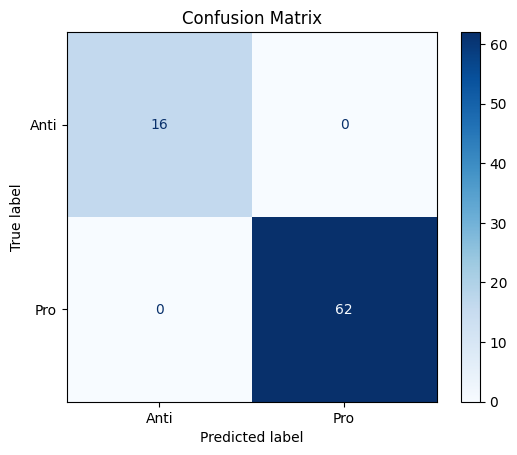


Examples from each prediction category:

--- TP ---
[1] today, in an historic win for bodily autonomy and lgbtq + ohioans, a three judge panel on the tenth district court of appeals overturned house bill 68, ohio ’ s law banning gender - affirming medical care for trans youth, and prohibiting trans women and girls from participating in sports. the case, ...

[2] in mid - february, news broke of the horrific murder of transgender man sam nordquist, in new york. we here at glaad stand in solidarity with sam ’ s loved ones as they demand justice. news of sam ’ s death and the now seven individuals charged in connection with his death was picked up by media in ...

--- TN ---
[1] a group of 12 students sued the department of defense education activity ( dodea ) over changes that have been made to curriculum and book removals in its schools. the lawsuit accuses the dodea of eliminating curriculum that deals with subjects such as slavery, native american history, and lgbtq iss...

[2] the u

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Evaluation mode
model.eval()
all_preds, all_labels, all_topics, all_texts = [], [], [], []

with torch.no_grad():
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attn_mask = batch["attention_mask"].to(device)
        topic_id = batch["topic_id"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attn_mask, topic_id)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_topics.extend(batch["topic_id"].numpy())
        all_texts.extend(tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True))

# 1. Classification report
report = classification_report(all_labels, all_preds, target_names=["Anti", "Pro"], output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nClassification Report:\n")
print(df_report.round(3))

# 2. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Anti", "Pro"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 3. Show sample texts from each group
examples = {"TP": [], "TN": [], "FP": [], "FN": []}
for text, true, pred in zip(all_texts, all_labels, all_preds):
    if true == 1 and pred == 1 and len(examples["TP"]) < 2:
        examples["TP"].append(text)
    elif true == 0 and pred == 0 and len(examples["TN"]) < 2:
        examples["TN"].append(text)
    elif true == 0 and pred == 1 and len(examples["FP"]) < 2:
        examples["FP"].append(text)
    elif true == 1 and pred == 0 and len(examples["FN"]) < 2:
        examples["FN"].append(text)

print("\nExamples from each prediction category:\n")
for label, texts in examples.items():
    print(f"--- {label} ---")
    for i, t in enumerate(texts):
        print(f"[{i+1}] {t[:300]}...\n")  # Print first 300 chars

Epoch 01 │ Loss 9.0404 │ Accuracy 72.58%
Epoch 02 │ Loss 8.0477 │ Accuracy 79.03%
Epoch 03 │ Loss 6.3754 │ Accuracy 80.65%
Epoch 04 │ Loss 4.4545 │ Accuracy 83.87%
Epoch 05 │ Loss 2.4814 │ Accuracy 100.00%

Classification Report:

              precision  recall  f1-score  support
Anti              1.000   0.667     0.800    3.000
Pro               0.929   1.000     0.963   13.000
accuracy          0.938   0.938     0.938    0.938
macro avg         0.964   0.833     0.881   16.000
weighted avg      0.942   0.938     0.932   16.000


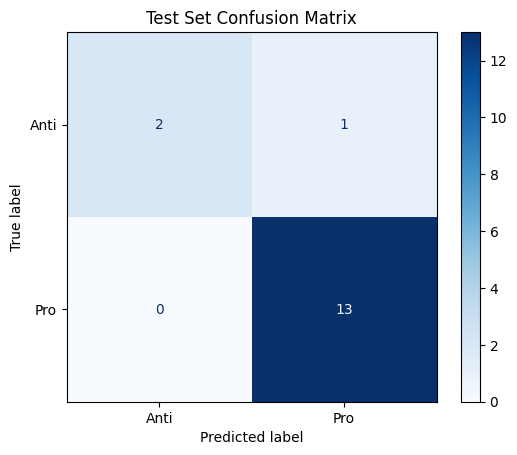


Examples from each prediction category:

--- TP ---
[1] a federal judge ruled monday that two fathers cannot wear pink wristbands with two x ’ s — the symbol for female chromosomes — drawn on them in opposition to a transgender high school athlete on one of their daughters ’ rival soccer teams. kyle fellers and anthony foote sued administrators at bow hi...

[2] the fiscal year 2024 appropriations process has been littered with anti - lgbtq attacks. republican members of the house of representatives have inserted anti - lgbtq provisions into all 12 of the must - pass appropriations bills. these riders include restrictions on gender - affirming care, allowan...

--- TN ---
[1] the u. s. department of agriculture announced wednesday that the university of maine system ( ums ) has agreed to comply with president donald trump's executive order to keep transgender athletes out of women's sports. ums, a network of eight public universities in maine, claims it has been complian...

[2] educa

In [47]:
# pip install torch transformers pandas scikit-learn matplotlib

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import DistilBertTokenizer, DistilBertModel
from torch.optim import AdamW
import torch.nn as nn
import matplotlib.pyplot as plt

# Load and clean data
df = pd.read_csv("articles.csv")
df.columns = df.columns.str.strip()
df = df.dropna(subset=["Content:", "Topic #:", "Pro-Anti:"])
df = df.rename(columns={"Content:": "content", "Topic #:": "topic", "Pro-Anti:": "stance"})
df["stance"] = df["stance"].str.strip()
df = df[df["stance"].isin(["Pro", "Anti"])]
df["label"] = df["stance"].map({"Pro": 1, "Anti": 0}).astype(int)
topic_encoder = LabelEncoder()
df["topic_id"] = topic_encoder.fit_transform(df["topic"].astype(str))

# Split dataset
texts = df["content"].tolist()
topics = df["topic_id"].values
labels = df["label"].values
X_train, X_test, t_train, t_test, y_train, y_test = train_test_split(
    texts, topics, labels, test_size=0.2, random_state=42, stratify=labels
)

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Dataset class
class ArticleDataset(Dataset):
    def __init__(self, texts, topics, labels, tokenizer, max_len=256):
        self.texts = texts
        self.topics = topics
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        topic_id = self.topics[idx]
        label = self.labels[idx]
        enc = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "topic_id": torch.tensor(topic_id),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Model
class StanceClassifier(nn.Module):
    def __init__(self, topic_vocab_size, topic_emb_dim=32, bert_model="distilbert-base-uncased"):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained(bert_model)
        self.topic_emb = nn.Embedding(topic_vocab_size, topic_emb_dim)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size + topic_emb_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, input_ids, attention_mask, topic_id):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_embed = outputs.last_hidden_state[:, 0, :]
        topic_embed = self.topic_emb(topic_id)
        x = torch.cat((text_embed, topic_embed), dim=1)
        return self.classifier(x)

# Loaders and setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = ArticleDataset(X_train, t_train, y_train, tokenizer)
test_dataset = ArticleDataset(X_test, t_test, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

model = StanceClassifier(topic_vocab_size=len(df["topic_id"].unique())).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(5):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attn_mask = batch["attention_mask"].to(device)
        topic_id = batch["topic_id"].to(device)
        labels = batch["label"].to(device).long()

        optimizer.zero_grad()
        outputs = model(input_ids, attn_mask, topic_id)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += len(labels)
        total_loss += loss.item()

    acc = correct / total
    print(f"Epoch {epoch+1:02d} │ Loss {total_loss:.4f} │ Accuracy {acc:.2%}")

# Evaluation
model.eval()
all_preds, all_labels, all_texts = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attn_mask = batch["attention_mask"].to(device)
        topic_id = batch["topic_id"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attn_mask, topic_id)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_texts.extend(tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True))

# Report
report = classification_report(all_labels, all_preds, target_names=["Anti", "Pro"], output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nClassification Report:\n")
print(df_report.round(3))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Anti", "Pro"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Set Confusion Matrix")
plt.show()

# Examples
examples = {"TP": [], "TN": [], "FP": [], "FN": []}
for text, true, pred in zip(all_texts, all_labels, all_preds):
    if true == 1 and pred == 1 and len(examples["TP"]) < 2:
        examples["TP"].append(text)
    elif true == 0 and pred == 0 and len(examples["TN"]) < 2:
        examples["TN"].append(text)
    elif true == 0 and pred == 1 and len(examples["FP"]) < 2:
        examples["FP"].append(text)
    elif true == 1 and pred == 0 and len(examples["FN"]) < 2:
        examples["FN"].append(text)

print("\nExamples from each prediction category:\n")
for label, texts in examples.items():
    print(f"--- {label} ---")
    for i, t in enumerate(texts):
        print(f"[{i+1}] {t[:300]}...\n")

In [31]:
# pip install torch transformers pandas scikit-learn

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from sklearn.utils import shuffle
from collections import defaultdict

# 1. Load and clean your dataset
df = pd.read_csv("articles.csv")
df.columns = df.columns.str.strip()
df = df.rename(columns={"Content:": "content", "Topic #:": "topic", "Pro-Anti:": "stance"})
df["stance"] = df["stance"].str.strip()
df = df[df["stance"].isin(["Pro", "Anti"])]

# 2. Group by topic and form (Pro, Anti) pairs
pairs = []
topic_groups = df.groupby("topic")
for topic, group in topic_groups:
    pros = group[group["stance"] == "Pro"]["content"].tolist()
    antis = group[group["stance"] == "Anti"]["content"].tolist()
    for pro in pros:
        for anti in antis:
            pairs.append((str(topic), pro, anti))  # prompt, good, bad

print(f"Generated {len(pairs)} (Pro vs Anti) pairs from topics.")

# 3. Define reward model
class RewardModel(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased"):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.head = nn.Linear(self.transformer.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        cls_embed = output.last_hidden_state[:, 0]
        score = self.head(cls_embed)
        return score.squeeze(-1)

# 4. Training setup
device = torch.device("mps")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = RewardModel().to(device)
optimizer = Adam(model.parameters(), lr=2e-5)

# 5. Training loop
def compute_pairwise_loss(prompt, good, bad):
    good_batch = tokenizer(prompt, good, return_tensors="pt", padding=True, truncation=True).to(device)
    bad_batch = tokenizer(prompt, bad, return_tensors="pt", padding=True, truncation=True).to(device)
    good_score = model(**good_batch)
    bad_score = model(**bad_batch)
    loss = -F.logsigmoid(good_score - bad_score).mean()
    return loss, good_score.item(), bad_score.item()

epochs = 5
model.train()
for epoch in range(epochs):
    total_loss = 0
    print(f"\nEpoch {epoch+1}")
    for i, (prompt, good, bad) in enumerate(shuffle(pairs)):
        optimizer.zero_grad()
        loss, good_s, bad_s = compute_pairwise_loss(prompt, good, bad)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if i % 20 == 0:
            print(f"[{i}/{len(pairs)}] Loss: {loss.item():.4f}, Good: {good_s:.3f}, Bad: {bad_s:.3f}")

    print(f"Epoch {epoch+1} complete. Avg Loss: {total_loss/len(pairs):.4f}")

Generated 50 (Pro vs Anti) pairs from topics.

Epoch 1
[0/50] Loss: 0.6722, Good: 0.104, Bad: 0.062
[20/50] Loss: 0.5862, Good: 0.517, Bad: 0.290
[40/50] Loss: 1.0754, Good: 0.388, Bad: 1.046
Epoch 1 complete. Avg Loss: 0.4081

Epoch 2
[0/50] Loss: 0.0418, Good: 1.806, Bad: -1.349
[20/50] Loss: 0.0024, Good: 3.780, Bad: -2.250
[40/50] Loss: 0.0020, Good: 3.513, Bad: -2.680
Epoch 2 complete. Avg Loss: 0.0093

Epoch 3
[0/50] Loss: 0.0028, Good: 3.545, Bad: -2.338
[20/50] Loss: 0.0023, Good: 3.347, Bad: -2.726
[40/50] Loss: 0.0009, Good: 4.438, Bad: -2.585
Epoch 3 complete. Avg Loss: 0.0018

Epoch 4
[0/50] Loss: 0.0006, Good: 4.467, Bad: -2.960
[20/50] Loss: 0.0009, Good: 4.439, Bad: -2.564
[40/50] Loss: 0.0004, Good: 4.930, Bad: -2.842
Epoch 4 complete. Avg Loss: 0.0010

Epoch 5
[0/50] Loss: 0.0008, Good: 4.241, Bad: -2.938
[20/50] Loss: 0.0004, Good: 4.978, Bad: -2.887
[40/50] Loss: 0.0006, Good: 4.508, Bad: -2.849
Epoch 5 complete. Avg Loss: 0.0007


In [ ]:
e